In [1]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu
from skimage.transform import resize
from collections import defaultdict
import pandas as pd
import os
from collections import defaultdict
import pickle

% matplotlib inline

In [2]:
class ROI:
    
    def __init__(self, filename, border, character, flipped):
        dataset = pydicom.dcmread(filename)
        a = dataset.pixel_array
        
        if a.shape[0] < 1000:
            fl = list(filename)
            if fl[-5] == '0':
                fl[-5] = '1'
                filename = "".join(fl)
            else:
                fl[-5] = '0'
                filename = ''.join(fl)
                
        dataset = pydicom.dcmread(filename)
        a = dataset.pixel_array
        '''
        if "LEFT" in filename:
            self.mode = 'left'
        else:
            self.mode = 'right'
            a = a[:,::-1]
        '''
        if flipped:
            a = a[:, ::-1]
        
        self.filename = filename
        self.image = resize(a[:, :border], (227,227))
        self.character = character
        
    def plot_contour(self):
        if self.character == 'benign':
            plt.contour(self.image, cmap = 'plasma', linewidths = 0.5 )
        else:
            plt.contour(self.image, cmap = 'winter', linewidths = 0.5 )


class Photo:
    
    def find_border(self, x):
    
        '''
        arr = np.sum(x[1000:4000, :], axis = 0)
        i = 0
        while(arr[i] > 0):
            i += 1
        return i
        '''
        arr = np.sum(x[1000:4000, :], axis = 1)
        #plt.plot(range(len(arr)), arr)
        am = np.argmax(arr)
        #print(am)
        
        for i in range(x.shape[1] - 100 , 0 , -1):
            if x[1000 + am, i] > 0:
                return i
    
    def plot_image(self):
        
        plt.imshow(self.image, cmap = 'gray')
        
        for roi in  self.m_rois:
            roi.plot_contour()
            
        for roi in  self.b_rois:
            roi.plot_contour()
            
        plt.show()
            
    
    def __init__(self, filename, filenames_ROI_m, filenames_ROI_b):
        dataset = pydicom.dcmread(filename)
        a = dataset.pixel_array
        
        '''
        if "LEFT" in filename:
            self.mode = 'left'
        else:
            self.mode = 'right'
            a = a[:,::-1]
        '''

            
        self.filename = filename
        self.threshold = threshold_otsu(a)
        
        self.flipped = False
        
        temp = a > self.threshold
        if np.sum(temp[:, :temp.shape[1] // 2]) > np.sum(temp[:, temp.shape[1] // 2:]):
            self.mode = 'left'
        else:
            self.mode = 'right'
            a = a[:,::-1]
            self.flipped = True
        
        self.border = self.find_border(a > self.threshold)

        
        
        #plt.imshow(a > self.threshold, cmap = 'gray')
        
        self.image = resize(a[:, :self.border], (227,227))
        
        self.m_rois = []
        self.b_rois = []
        
        for fn in filenames_ROI_m:
            self.m_rois.append(ROI(fn, self.border, 'malignant', self.flipped))
        
        for fn in filenames_ROI_b:
            self.b_rois.append(ROI(fn, self.border, 'benign', self.flipped))
        
        

C:\Users\Sergey\AppData\Local\conda\conda\envs\condathree\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


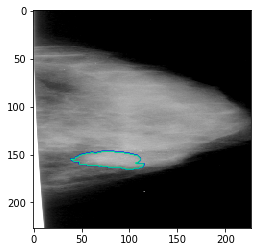

In [3]:
filename = "CBIS-DDSM/Mass-Test_P_00016_LEFT_CC/10-04-2016-DDSM-30104/1-full mammogram images-14172/000000.dcm"
f1 = "CBIS-DDSM/Mass-Test_P_00016_LEFT_CC_1/10-04-2016-DDSM-09887/1-cropped images-26184/000001.dcm"
filenames_ROI_m = [f1]
filenames_ROI_b = []

ph = Photo(filename, filenames_ROI_m, filenames_ROI_b)
ph.plot_image()

In [4]:
def cut_name(x):
    fst = x.find("/")
    scnd = fst + x[fst + 1:].find('/') + 1
    return x[fst+1:scnd]

In [ ]:
def parse_name(filename):
    ind = 10 + filename[10:].find('/')
    sp = filename[10:ind]

    if '0' <= sp[-1] <= '9':
        return sp[:-2], sp, filename + '/000001.dcm' , 0
    else:
        return sp, sp,  filename + '/000000.dcm', 1
    

originals_mass = dict()
rois_mass = defaultdict(dict)

for root, dirs, files in os.walk("CBIS-DDSM/"):  
    for filename in files:
        if 'Mass' in root:
            entity, name,  addr, reg = parse_name(root.replace('\\', '/'))
            if reg == 0:
                rois_mass[entity][name] = addr
            else:
                originals_mass[entity] = addr
                
#calc_test = pd.read_csv("calc_case_description_test_set.csv")
#calc_train = pd.read_csv("calc_case_description_train_set.csv")
mass_test = pd.read_csv("mass_case_description_test_set.csv")
mass_train = pd.read_csv("mass_case_description_train_set.csv")

mass_dict = {}

for pat_id, direct, view, abn_id, pathology in  mass_test.loc[:,("patient_id", 'left or right breast',\
                                                                'image view', 'abnormality id', 'pathology')].values:
    mass_dict['Mass-Test_' + pat_id + '_' + direct + '_' + view + '_' + str(abn_id)] = pathology


for pat_id, direct, view, abn_id, pathology in  mass_train.loc[:,("patient_id", 'left or right breast',\
                                                                'image view', 'abnormality id', 'pathology')].values:
    if pathology != 'MALIGNANT':
        pathology = 'BENIGN'
    mass_dict['Mass-Training_' + pat_id + '_' + direct + '_' + view + '_' + str(abn_id)] = pathology
    


In [ ]:
#MASS = []
for entity in originals_mass.keys():
    mal = []
    ben = []
    rois = rois_mass[entity]
    for roi in rois.keys():
        if mass_dict[roi] == 'BENIGN':
            ben.append(rois[roi])
        else:
            try:
                mal.append(rois[roi])
            except Exception as e:
                print('*********************************************')
                print(rois[roi])
                print(e)
    try:
        ph = Photo(originals_mass[entity], mal, ben)
        print(ph.filename)
        print(ph.mode)
        ph.plot_image()
        
        with open('Data/' + cut_name(ph.filename), 'wb') as filehandler:
            pickle.dump(ph, filehandler)
        #MASS.append(ph)
        #stop = int(input("Stop?"))
        #if stop == 1:
        #    break
        
    except Exception as e:
        print('********************************************')
        print(rois[roi])
        print(e)

In [34]:
import keras
from keras.applications import  xception#mobilenet_v2,
from keras.layers import Input, Convolution2D, Lambda, Flatten
import tensorflow as tf
from keras.optimizers import Adam
from keras import regularizers
from keras.models import Model

def create_model(m, lambd_reg, learning_rate):
    inp = m.input#m.get_layer(name = 'input_2').output
    out = m.get_layer(name = 'block14_sepconv2_act').output
    m1 = Model(inputs = inp, outputs = out)

    inter = m1.output
    conv = Convolution2D(1, (1,1), name = 'Conv_Sigmoid', activation = 'sigmoid')
    flat = Flatten(name = 'Flatten')
    lda = Lambda(lambda x: tf.contrib.framework.sort(x, axis=-1, direction = 'DESCENDING'), name="Sort")

    out = lda(flat(conv(inter)))
    
    m2 =  Model(inputs = inp, outputs = out)
    
    for layer in m2.layers:
        layer.kernel_regularizer = regularizers.l2(lambd_reg)
        layer.bias_regularizer = regularizers.l2(lambd_reg)
    
    adam = Adam(learning_rate)
    m2.compile(optimizer = adam, loss = keras.losses.categorical_crossentropy)
    return m2


class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=4, dim=(227,227), n_channels=3,
                 n_classes=10, shuffle=True, TOP_K = 5, OUT_SIZE = 49):
        'Initialization'
        
        self.dim = dim # ?-1
        
        self.batch_size = batch_size
        #self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        #self.n_classes = n_classes ?-2
        self.shuffle = shuffle
        self.on_epoch_end()
        self.TOP_K = TOP_K
        self.OUT_SIZE = OUT_SIZE
        self.aug = ImageDataGenerator(rotation_range=45, width_shift_range=0.1,\
                                      height_shift_range=0.1, horizontal_flip=True)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.OUT_SIZE), dtype='int32')
        
        photo = 0
        # Generate data
        #print(len(list_IDs_temp))
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            
            with open('Data/' + ID, 'rb') as filehandler:
                photo = pickle.load(filehandler)
                
            #photo = np.load('data/' + ID + '.npy')
            img = photo.image
            
            XX = np.repeat(img.reshape(*self.dim, 1), 3, axis=2)   
            params = self.aug.get_random_transform(XX.shape)
            
            X[i,] = self.aug.apply_transform(XX, params)
            
            yy = np.zeros(self.OUT_SIZE, dtype = 'int32')
            
            if len(photo.m_rois) == 0:
                y[i,] = yy
            else:
                yy[:self.TOP_K] = 1
                y[i,] = yy
                

        return X, y

In [25]:
training_generator = DataGenerator(train_namespace)


In [27]:
training_generator.flow()

AttributeError: 'DataGenerator' object has no attribute 'flow'

In [32]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit parameters from data
datagen.fit(x =  training_generator)



TypeError: __init__() got multiple values for argument 'featurewise_center'

In [35]:
training_generator = DataGenerator(train_namespace)

In [42]:
training_generator.__getitem__(2)[0].shape

(4, 227, 227, 3)

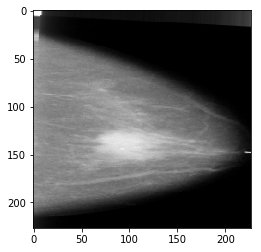

In [50]:
plt.imshow(training_generator.__getitem__(2)[0][0,:,:,0], cmap = 'gray')

In [23]:
import random
import pickle

namespace = set(list(os.walk('Data/'))[0][2])
namespace = namespace - {'Mass-Training_P_00023_RIGHT_MLO'}
namespace = list(namespace)

random.shuffle(namespace)

N_train = 1200

train_namespace = namespace[:N_train]
val_namespace = namespace[N_train:]

training_generator = DataGenerator(train_namespace)
validation_generator = DataGenerator(val_namespace)

mm.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=False,
                    workers=6, verbose = 1, epochs = 3)

ValueError: `steps_per_epoch=None` is only valid for a generator based on the `keras.utils.Sequence` class. Please specify `steps_per_epoch` or use the `keras.utils.Sequence` class.

In [ ]:
c = 0
p = 0

for name in namespace:
    with open('Data/' + name, 'rb') as filehandler:
        p = pickle.load(filehandler)
    if len(p.m_rois) > 0:
        c += 1
        

In [ ]:
c

In [ ]:
mm.summary()

In [9]:
model_print = Model(inputs = mm.input, outputs = mm.get_layer(name = 'Conv_Sigmoid').output)

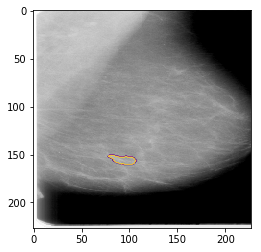

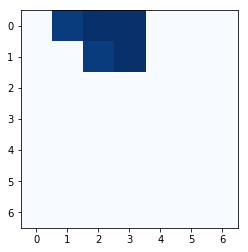

In [16]:


photo = 0

ID = val_namespace[60]
with open('Data/' + ID, 'rb') as filehandler:
    photo = pickle.load(filehandler)
    
pred = model_print.predict(np.array([np.repeat((photo.image).reshape(227,227, 1), 3, axis=2)]))
photo.plot_image()
plt.imshow(pred.reshape((7,7)), cmap = 'Blues')

In [ ]:
pred = model_print.predict(np.array([np.repeat((photo.image).reshape(227,227, 1), 3, axis=2)]))

In [ ]:
photo.plot_image()

In [ ]:
plt.imshow(pred.reshape((7,7)), cmap = 'gray')

In [6]:
model = xception.Xception(include_top=False, weights='imagenet', input_shape=(227,227,3) , pooling='avg')
#model = mobilenet_v2.MobileNetV2(input_shape=(224,224,3), alpha=1.3, depth_multiplier=1, include_top=False, weights='imagenet', input_tensor=None, pooling= 'avg')

mm = create_model(model, lambd_reg = 1e-5, learning_rate = 5e-5)



In [ ]:
tf.reset_default_graph()

In [ ]:
model.summary()

In [ ]:
photo = 0

ID = train_namespace[203]
with open('Data/' + ID, 'rb') as filehandler:
    photo = pickle.load(filehandler)

In [ ]:
'Data/' + ID

In [ ]:
filehandler